# Topic Modeling and sentiment analaysis

## Topic modeling

Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

Dimensionality Reduction, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}



There are several existing algorithms we can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)


In this article, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python.

# LDA Implementation

The steps used to implement LDA :
   1) Loading data
   
   2) Data cleaning
   
   
   3) Exploratory analysis
   
   
   4) Preparing data for LDA analysis
   
   
   5) LDA model training
   
   
   6) Analyzing LDA model results

# Step 1: Loading Data 

In [21]:
# Importing modules
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import os
import re

#os.chdir('..')

# Read data into papers
papers = pd.read_csv('week_0_challenge_3/processed_tweet_data .csv')

# Print head
papers.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,NaN,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,NaN,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1,LeeTomlinson8,1195,1176,NaN,"[{'text': 'red4research', 'indices': [103, 116]}]","[{'screen_name': 'NHSRDForum', 'name': 'NHS R&...",NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899,RIPNY08,2666,2704,NaN,[],"[{'screen_name': 'HighWireTalk', 'name': 'The ...",NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20,pash22,28250,30819,NaN,[],"[{'screen_name': 'PeterHotez', 'name': 'Prof P...",United Kingdom


# Step 2: Data Cleaning

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns.

In [22]:
# Remove the columns
papers = papers.drop(columns=['favorite_count','possibly_sensitive','user_mentions'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,created_at,source,original_text,polarity,subjectivity,lang,retweet_count,original_author,followers_count,friends_count,hashtags,place
2599,Fri Jun 18 22:03:05 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",The Palestinian Authority (PA) cancels a deal ...,0.000000,0.000000,en,6,autobushaya,2198,1069,"[{'text': 'COVID19', 'indices': [91, 99]}, {'t...",port said/Cairo-Egypt
3619,Sat Jun 19 00:44:01 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",We are dying! Ugandans need the world to stand...,-0.236458,0.337500,en,552,kayakkim11,351,413,"[{'text': 'COVID19', 'indices': [101, 109]}]","New Jersey, USA"
4737,Sat Jun 19 03:23:34 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",The #Palestinian Authority canceled a deal to ...,0.000000,0.000000,en,0,GlobalWatchCGTN,1639,255,"[{'text': 'Palestinian', 'indices': [4, 16]}, ...",NaN
2957,Fri Jun 18 22:53:15 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Of course you're not going to be inclined to a...,-0.133333,0.600000,en,0,esrasez94,3657,616,[],Melbourne 🔁 Istanbul
5848,Sat Jun 19 06:04:05 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,284,ParallaxUtopian,83,476,[],"San Antonio, TX"


## Remove punctuation/lower casing

In [23]:
# Load the regular expression library

import re

# Remove punctuation

papers['paper_text_processed'] = \
papers['original_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase

papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers

papers['paper_text_processed'].head()


2599    the palestinian authority (pa) cancels a deal ...
3619    we are dying ugandans need the world to stand ...
4737    the #palestinian authority canceled a deal to ...
2957    of course you're not going to be inclined to a...
5848    dr moeti is head of who in africa and one of t...
Name: paper_text_processed, dtype: object

# Step 3: Exploratory Analysis

To verify whether the preprocessing, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

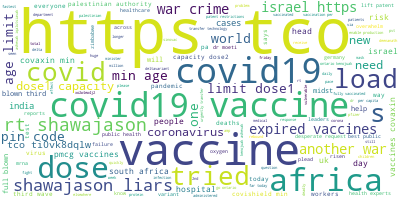

In [24]:
# Import the wordcloud library

from wordcloud import WordCloud

# Join the different processed titles together.

long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud

wordcloud.generate(long_string)

# Visualize the word cloud

wordcloud.to_image()

# Step 4 Prepare data for LDA Analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [25]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eyerusalem/nltk_data...


['palestinian', 'authority', 'pa', 'cancels', 'deal', 'receive', 'soon', 'expire', 'covid', 'vaccines', 'israel', 'initial', 'israeli', 'shipment', 'showed', 'expiration', 'date', 'sooner', 'agreed', 'pa', 'health', 'minister', 'says', 'https', 'tco', 'slikympzd']


[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
import gensim.corpora as corpora

# Create Dictionary
id_to_word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id_to_word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]


# Step 5: LDA model tranining 